<a href="https://colab.research.google.com/github/Juhyeon-creater/Sessac-project2/blob/main/Lunge_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.1 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.1.5 which is incompatible.


In [ ]:
# 왼쪽 사이드바 '열쇠 모양(보안 비밀)'에 HF_TOKEN 이라는 이름으로 토큰을 저장하고 아래 코드 실행
from google.colab import userdata
from huggingface_hub import login
import pandas as pd

try:
    token = userdata.get('g')
    login(token)
except:
    login() # 직접 입력창이 뜨면 토큰 붙여넣기

splits = {'train': 'train03.json', 'test': 'test03.json'}
df = pd.read_json("hf://datasets/guyuchao/UCF101/" + splits["train"])

In [ ]:
df

,video_path,label
0,datasets/ucf101/video/ApplyEyeMakeup/v_ApplyEy...,0
1,datasets/ucf101/video/BabyCrawling/v_BabyCrawl...,3
2,datasets/ucf101/video/Diving/v_Diving_g13_c05.mp4,25
3,datasets/ucf101/video/BlowDryHair/v_BlowDryHai...,12
4,datasets/ucf101/video/WritingOnBoard/v_Writing...,99
...,...,...
9619,datasets/ucf101/video/BandMarching/v_BandMarch...,5
9620,datasets/ucf101/video/LongJump/v_LongJump_g03_...,50
9621,datasets/ucf101/video/Mixing/v_Mixing_g24_c01.mp4,53
9622,datasets/ucf101/video/PlayingViolin/v_PlayingV...,66


In [ ]:
import tarfile
from huggingface_hub import hf_hub_download
import os

repo_id = "guyuchao/UCF101"
target_keyword = "Lunges" # 찾을 키워드

# 저장할 폴더 생성
save_dir = "./my_lunge_dataset"
os.makedirs(save_dir, exist_ok=True)

shards = ["shard-00000.tar", "shard-00001.tar"]
total_count = 0

print(f"🚀 '{target_keyword}' 영상 전체 추출을 시작합니다...")

for shard_name in shards:
    try:
        print(f"\n📦 {shard_name} 검사 중...")

        # 1. tar 파일 다운로드
        archive_path = hf_hub_download(repo_id=repo_id, filename=shard_name, repo_type="dataset")

        # 2. tar 파일 열기
        with tarfile.open(archive_path, "r") as tar:
            # 압축 파일 내의 모든 파일 목록을 가져옵니다.
            all_members = tar.getmembers()

            # 'Lunges'가 포함된 비디오 파일만 골라냅니다.
            lunge_members = [m for m in all_members if target_keyword in m.name and m.name.endswith(('.avi', '.mp4'))]

            if lunge_members:
                print(f"   -> {len(lunge_members)}개의 런지 영상을 발견했습니다. 추출 시작...")

                # 3. 추출 실행
                for member in lunge_members:
                    # 경로를 단순화하지 않고 그대로 추출 (폴더 구조 유지됨)
                    tar.extract(member, path=save_dir)
                    total_count += 1
            else:
                print("   -> 이 압축 파일에는 런지 영상이 없습니다.")

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")

print(f"\n🎉 작업 완료! 총 {total_count}개의 런지 영상을 추출했습니다.")
print(f"📂 저장 위치: {save_dir} 폴더 내부를 확인해보세요.")

🚀 'Lunges' 영상 전체 추출을 시작합니다...

📦 shard-00000.tar 검사 중...


shard-00000.tar:   0%|          | 0.00/2.60G [00:00<?, ?B/s]

   -> 96개의 런지 영상을 발견했습니다. 추출 시작...

📦 shard-00001.tar 검사 중...


/tmp/ipython-input-1206155420.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, path=save_dir)


shard-00001.tar:   0%|          | 0.00/889M [00:00<?, ?B/s]

   -> 31개의 런지 영상을 발견했습니다. 추출 시작...

🎉 작업 완료! 총 127개의 런지 영상을 추출했습니다.
📂 저장 위치: ./my_lunge_dataset 폴더 내부를 확인해보세요.


In [ ]:
# 1. YOLO 라이브러리 설치
!pip install -U ultralytics

import cv2
import numpy as np
import pandas as pd
import glob
import os
from ultralytics import YOLO
from tqdm import tqdm # 진행상황 바 표시용

# 2. 모델 로드 (처음 실행 시 자동으로 다운로드됩니다)
# 사용자가 원했던 11s-pose 모델 사용
model = YOLO('yolo11x-pose.pt')

print("모델 로드 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
모델 로드 완료!


In [ ]:
# --- 유틸리티 함수: 세 점 사이의 각도 계산 ---
def calculate_angle(a, b, c):
    a = np.array(a) # 엉덩이
    b = np.array(b) # 무릎 (중심점)
    c = np.array(c) # 발목

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

# --- 데이터 추출 메인 로직 ---
def process_videos(video_paths, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for video_path in tqdm(video_paths, desc="영상 분석 중"):
        cap = cv2.VideoCapture(video_path)
        video_name = os.path.basename(video_path).split('.')[0]

        frame_data = []
        frame_idx = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # YOLO 추론 (verbose=False로 로그 숨김)
            results = model(frame, verbose=False)

            # 사람이 감지되었을 때만 처리
            if results[0].keypoints is not None and len(results[0].keypoints) > 0:
                # 가장 신뢰도 높은 한 사람(0번 인덱스)만 가져옴
                keypoints = results[0].keypoints.xyn[0].cpu().numpy() # 정규화된 좌표 (0~1)

                # YOLO Keypoint Map:
                # 5:L_Shoulder, 6:R_Shoulder, 11:L_Hip, 12:R_Hip,
                # 13:L_Knee, 14:R_Knee, 15:L_Ankle, 16:R_Ankle

                # 좌표 추출
                l_hip, l_knee, l_ankle = keypoints[11], keypoints[13], keypoints[15]
                r_hip, r_knee, r_ankle = keypoints[12], keypoints[14], keypoints[16]

                # 각도 계산 (0도에 가까우면 접힌 것, 180도면 펴진 것)
                angle_l_knee = calculate_angle(l_hip, l_knee, l_ankle)
                angle_r_knee = calculate_angle(r_hip, r_knee, r_ankle)

                # 데이터 저장 (필요한 Feature만 선별)
                frame_data.append({
                    'frame': frame_idx,
                    'l_knee_angle': angle_l_knee,
                    'r_knee_angle': angle_r_knee,
                    'l_hip_y': l_hip[1], # 엉덩이 높이 (앉았다 일어났다 판별용)
                    'r_hip_y': r_hip[1],
                    # 런지 자세 분류를 위해 발목 간의 x축 거리 차이도 유용함
                    'ankle_dist_x': abs(l_ankle[0] - r_ankle[0])
                })

            frame_idx += 1

        cap.release()

        # CSV 저장 (데이터가 존재할 경우에만)
        if len(frame_data) > 0:
            df = pd.DataFrame(frame_data)
            save_path = os.path.join(output_folder, f"{video_name}.csv")
            df.to_csv(save_path, index=False)

# --- 실행 ---
# 1. 영상 경로 리스트 가져오기
input_dir = "/content/my_lunge_dataset/video/Lunges" # 아까 저장된 경로
video_files = glob.glob(f"{input_dir}/*.mp4") + glob.glob(f"{input_dir}/*.avi")

print(f"총 {len(video_files)}개의 영상을 분석합니다...")

# 2. 처리 시작 (결과는 ./lunge_features 폴더에 저장)
process_videos(video_files, "./lunge_features")

print("\n모든 분석이 완료되었습니다! './lunge_features' 폴더를 확인하세요.")

총 127개의 영상을 분석합니다...


영상 분석 중: 100%|██████████| 127/127 [24:53<00:00, 11.76s/it]


모든 분석이 완료되었습니다! './lunge_features' 폴더를 확인하세요.


In [ ]:
from google.colab import drive
import shutil
import os

# 1. 구글 드라이브 마운트 (로그인 창이 뜨면 승인해주세요)
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# 2. 경로 설정
source_folder = './lunge_features'  # 코랩에 생성된 CSV 폴더
destination_folder = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Lunge' # 내 드라이브에 저장될 폴더명

print(f"복사를 시작합니다: {source_folder} -> {destination_folder}")

# 3. 드라이브에 저장
try:
    # 만약 드라이브에 같은 이름의 폴더가 있다면 삭제하고 새로 만듭니다 (깔끔하게 덮어쓰기)
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)
        print("기존 폴더를 덮어씁니다...")

    # 폴더 통째로 복사
    shutil.copytree(source_folder, destination_folder)

    print("\n✅ 저장 완료!")
    print(f"구글 드라이브에서 '[Lunge_Analysis_Data]' 폴더를 확인해보세요.")

    # 4. 잘 들어갔는지 파일 개수 확인
    file_count = len(os.listdir(destination_folder))
    print(f"-> 총 {file_count}개의 파일이 안전하게 저장되었습니다.")

except Exception as e:
    print(f"\n❌ 오류 발생: {e}")
    print("소스 폴더 이름이 정확한지, 혹은 드라이브 용량이 충분한지 확인해주세요.")

복사를 시작합니다: ./lunge_features -> /content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Lunge
기존 폴더를 덮어씁니다...

✅ 저장 완료!
구글 드라이브에서 '[Lunge_Analysis_Data]' 폴더를 확인해보세요.
-> 총 126개의 파일이 안전하게 저장되었습니다.


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. 설정
DATA_PATH = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Lunge'
SEQUENCE_LENGTH = 30  # 30프레임(약 1초)을 하나의 입력 단위로 봄
FEATURE_COLS = ['l_knee_angle', 'r_knee_angle', 'l_hip_y', 'r_hip_y', 'ankle_dist_x']

# 2. 데이터 로드 함수
def load_dataset(folder_path):
    all_files = glob.glob(f"{folder_path}/*.csv")
    sequences = []
    labels = [] # 0: Good, 1: Bad

    print(f"총 {len(all_files)}개의 파일을 로드합니다...")

    for file in all_files:
        df = pd.read_csv(file)

        # 필요한 컬럼만 선택
        if not all(col in df.columns for col in FEATURE_COLS):
            continue

        data = df[FEATURE_COLS].values

        # 데이터가 너무 짧으면 패스
        if len(data) < SEQUENCE_LENGTH:
            continue

        # --- 데이터 정규화 (MinMax) ---
        # 각도(0~180)나 좌표를 0~1 사이로 맞춰줘야 학습이 잘됨
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)

        # --- Sliding Window로 시퀀스 생성 ---
        # 영상 하나를 여러 개의 30프레임 조각으로 자름
        for i in range(len(data) - SEQUENCE_LENGTH):
            seq = data[i : i + SEQUENCE_LENGTH]

            # [Class 0] 정상 데이터 (Good)
            sequences.append(seq)
            labels.append(0)

            # [Class 1] 가짜 불량 데이터 생성 (Bad)
            # 정상 데이터에 랜덤 노이즈를 섞어서 "흔들리는 자세"를 흉내냄
            noise = np.random.normal(0, 0.1, seq.shape) # 표준편차 0.1 정도의 노이즈
            bad_seq = seq + noise
            sequences.append(bad_seq)
            labels.append(1)

    return np.array(sequences), np.array(labels)

# 3. 실행
X, y = load_dataset(DATA_PATH)

# 학습용/테스트용 분리 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n데이터 준비 완료!")
print(f"입력 데이터 형태(X): {X_train.shape} (샘플수, 30프레임, 5개특징)")
print(f"정답 데이터 형태(y): {y_train.shape}")

총 126개의 파일을 로드합니다...

데이터 준비 완료!
입력 데이터 형태(X): (38918, 30, 5) (샘플수, 30프레임, 5개특징)
정답 데이터 형태(y): (38918,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. 모델 구조 정의
model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(FEATURE_COLS))))
model.add(Dropout(0.2)) # 과적합 방지

# 두 번째 LSTM 층
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# 출력층 (이진 분류이므로 sigmoid)
model.add(Dense(1, activation='sigmoid'))

# 2. 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# 3. 학습 시작 (Epochs는 횟수)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5006 - loss: 0.6942 - val_accuracy: 0.4972 - val_loss: 0.6932
Epoch 2/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5002 - loss: 0.6935 - val_accuracy: 0.4979 - val_loss: 0.6932
Epoch 3/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4982 - loss: 0.6935 - val_accuracy: 0.5039 - val_loss: 0.6932
Epoch 4/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4946 - loss: 0.6934 - val_accuracy: 0.5020 - val_loss: 0.6931
Epoch 5/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4999 - loss: 0.6933 - val_accuracy: 0.4942 - val_loss: 0.6933
Epoch 6/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5031 - loss: 0.6933 - val_accuracy: 0.5157 - val_loss: 0.6930
Epoch 7/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5072 - loss: 0.6930 - val_accuracy: 0.5232 - val_loss: 0.6898
Epoch 8/10
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5890 - loss

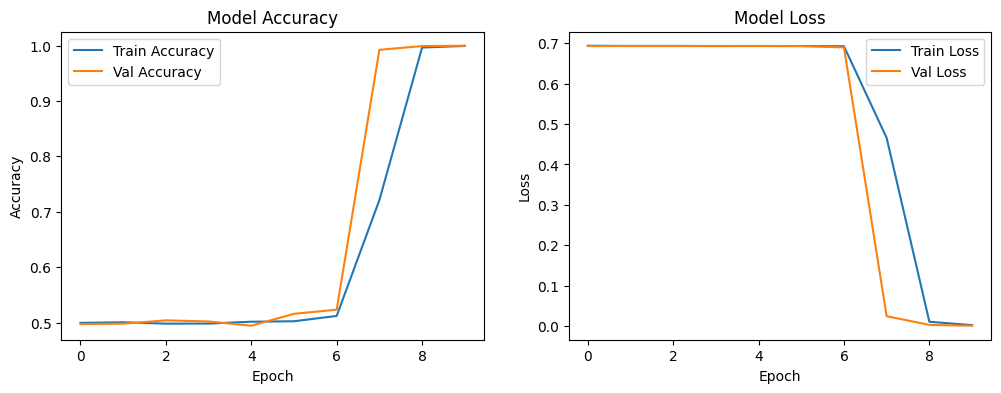

In [ ]:
import matplotlib.pyplot as plt

# 정확도와 손실값 그래프 그리기
plt.figure(figsize=(12, 4))

# 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/analysis/Lunge_model_acc_loss.png')
plt.show()

In [ ]:
def predict_pose(input_sequence, model):
    # input_sequence: (30, 5) 형태의 넘파이 배열

    # 차원 확장 (1, 30, 5) - 모델은 배치를 기대함
    input_data = np.expand_dims(input_sequence, axis=0)

    # 예측 (0~1 사이 값 출력)
    prediction = model.predict(input_data, verbose=0)[0][0]

    # 해석
    score = (1 - prediction) * 100 # 0(Good)일수록 100점, 1(Bad)일수록 0점

    if prediction < 0.5:
        status = "Good (안정적)"
    else:
        status = "Bad (불안정/흔들림)"

    return score, status

# --- 테스트: 테스트 데이터 중 하나를 뽑아서 넣어봄 ---
sample_idx = 10 # 임의의 인덱스
test_seq = X_test[sample_idx]
actual_label = y_test[sample_idx] # 0이면 원본, 1이면 노이즈 섞은 것

predicted_score, predicted_status = predict_pose(test_seq, model)

print(f"--- 테스트 결과 ---")
print(f"실제 라벨: {'Good' if actual_label == 0 else 'Bad'}")
print(f"모델 예측: {predicted_status}")
print(f"자세 점수: {predicted_score:.1f}점")

--- 테스트 결과 ---
실제 라벨: Good
모델 예측: Good (안정적)
자세 점수: 100.0점


In [ ]:
model.save('lunge_lstm_model.h5')

In [ ]:
import joblib
from google.colab import files

# 1. 모델 저장
model.save('lunge_lstm_model.h5')

# 2. 스케일러 저장 (학습할 때 썼던 기준값 저장)
# 주의: 앞선 코드에서 정의한 scaler 객체가 메모리에 있어야 합니다.
joblib.dump(scaler, 'scaler.pkl')

print("파일 저장 완료! 좌측 파일 탐색기에서 다운로드 받으세요:")
print("1. lunge_lstm_model.h5")
print("2. scaler.pkl")

# (선택) 자동 다운로드 트리거
files.download('lunge_lstm_model.h5')
files.download('scaler.pkl')

NameError: name 'scaler' is not defined

# 모델 재 학습

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import joblib # 저장용
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# --- 설정 ---
DATA_PATH = '/content/drive/MyDrive/shared_googledrive(Sessac Final Project)/dataset/Lunge'
SEQUENCE_LENGTH = 30
FEATURE_COLS = ['l_knee_angle', 'r_knee_angle', 'l_hip_y', 'r_hip_y', 'ankle_dist_x']

# --- 1. 스케일러를 '함수 밖(전역)'에 먼저 만듭니다 ---
# 이렇게 해야 나중에 저장이 가능합니다.
global_scaler = MinMaxScaler()

def load_and_process_data(folder_path):
    all_files = glob.glob(f"{folder_path}/*.csv")
    raw_sequences = [] # 스케일링 전 데이터를 모을 리스트

    print(f"총 {len(all_files)}개의 파일 데이터를 분석합니다...")

    # 1단계: 모든 파일의 데이터를 일단 하나로 모읍니다 (기준을 잡기 위해)
    temp_data_list = []
    valid_files = [] # 데이터가 충분한 파일 리스트

    for file in all_files:
        df = pd.read_csv(file)
        if all(col in df.columns for col in FEATURE_COLS):
            data = df[FEATURE_COLS].values
            if len(data) >= SEQUENCE_LENGTH:
                temp_data_list.append(data)
                valid_files.append(data) # 나중에 시퀀스 만들 때 사용

    # 전체 데이터 합치기 (학습용 기준점 잡기)
    all_data_concat = np.vstack(temp_data_list)

    # 2단계: 스케일러 학습 (Fit)
    # 전체 데이터의 최소/최대값을 여기서 확정합니다.
    global_scaler.fit(all_data_concat)
    print("스케일러 학습 완료 (전체 데이터 기준 MinMax 설정됨)")

    # 3단계: 시퀀스 생성 (Sliding Window)
    sequences = []
    labels = []

    for data in valid_files:
        # 위에서 학습된 스케일러로 변환 (Transform)
        scaled_data = global_scaler.transform(data)

        for i in range(len(scaled_data) - SEQUENCE_LENGTH):
            seq = scaled_data[i : i + SEQUENCE_LENGTH]

            # Good Data (0)
            sequences.append(seq)
            labels.append(0)

            # Bad Data (1) - 노이즈 추가
            noise = np.random.normal(0, 0.1, seq.shape)
            bad_seq = seq + noise
            sequences.append(bad_seq)
            labels.append(1)

    return np.array(sequences), np.array(labels)

# 실행
X, y = load_and_process_data(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n데이터 준비 완료: {X_train.shape}")

총 126개의 파일 데이터를 분석합니다...
스케일러 학습 완료 (전체 데이터 기준 MinMax 설정됨)

데이터 준비 완료: (38918, 30, 5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import files

# 1. 모델 정의 및 학습
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 5)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

# 2. 저장 (이제 에러가 안 날 겁니다)
print("\n파일 저장 및 다운로드 시작...")

# 모델 저장
model.save('lunge_lstm_model.h5')

# 스케일러 저장 (아까 밖에서 만든 global_scaler를 저장)
joblib.dump(global_scaler, 'scaler.pkl')

print("✅ 저장 완료!")

# 3. 다운로드 (브라우저 팝업 허용 필요)
files.download('lunge_lstm_model.h5')
files.download('scaler.pkl')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4991 - loss: 0.6943 - val_accuracy: 0.5054 - val_loss: 0.6931
Epoch 2/5
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5020 - loss: 0.6934 - val_accuracy: 0.4942 - val_loss: 0.6934
Epoch 3/5
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5043 - loss: 0.6933 - val_accuracy: 0.4942 - val_loss: 0.6935
Epoch 4/5
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.4922 - loss: 0.6934 - val_accuracy: 0.5036 - val_loss: 0.6931
Epoch 5/5
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5079 - loss: 0.6931 - val_accuracy: 0.5048 - val_loss: 0.6938



파일 저장 및 다운로드 시작...
✅ 저장 완료!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>